In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import re

url = 'https://raw.githubusercontent.com/liyuhao413/filepit/main/world-data-2023.csv'
data = pd.read_csv(url)
data.head()

,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626
3,Andorra,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,469,...,36.40%,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801
4,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,"34,693",...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887


In [47]:
non_numeric_columns = ['Density\n(P/Km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size', 
                       'Co2-Emissions', 'CPI', 'CPI Change (%)', 'Forested Area (%)', 'Gasoline Price', 'GDP',
                       'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 
                       'Minimum wage', 'Out of pocket health expenditure', 'Population', 
                       'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate', 
                       'Unemployment rate', 'Urban_population']

def convert_to_numeric(value):
    if pd.isnull(value):
        return None
    numeric_value = re.sub(r'[^0-9.]', '', str(value))
    try:
        return float(numeric_value)
    except ValueError:
        return None

data_cleaned = data.copy()
for col in non_numeric_columns:
    if col in data_cleaned.columns:
        data_cleaned[col] = data_cleaned[col].apply(convert_to_numeric)

numeric_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns

data_cleaned[numeric_columns] = data_cleaned[numeric_columns].fillna(data_cleaned[numeric_columns].median())

for col in categorical_columns:
    data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mode().iloc[0])

print(data_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density
(P/Km2)                            195 non-null    float64
 2   Abbreviation                               195 non-null    object 
 3   Agricultural Land( %)                      195 non-null    float64
 4   Land Area(Km2)                             195 non-null    float64
 5   Armed Forces size                          195 non-null    float64
 6   Birth Rate                                 195 non-null    float64
 7   Calling Code                               195 non-null    float64
 8   Capital/Major City                         195 non-null    object 
 9   Co2-Emissions                              195 non-null    float64
 10  CPI                       

In [48]:
numeric_data = data_cleaned.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

life_expectancy_correlation = correlation_matrix['Life expectancy'].sort_values(ascending=False)

print(life_expectancy_correlation)


Life expectancy                              1.000000
Gross tertiary education enrollment (%)      0.714983
Physicians per thousand                      0.676769
Minimum wage                                 0.480282
Latitude                                     0.461138
Tax revenue (%)                              0.342315
Gasoline Price                               0.236204
GDP                                          0.174424
Co2-Emissions                                0.117827
Gross primary education enrollment (%)       0.093737
Armed Forces size                            0.071427
Urban_population                             0.069028
Density\n(P/Km2)                             0.064183
Land Area(Km2)                               0.052961
Population                                   0.007450
Forested Area (%)                            0.005924
Calling Code                                -0.033359
Unemployment rate                           -0.043603
Longitude                   

In [49]:
X = data_cleaned.drop(['Life expectancy', 'Country', 'Abbreviation', 'Calling Code', 'Capital/Major City', 'Currency-Code', 'Official language', 'Largest city'], axis=1)
y = data_cleaned['Life expectancy']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_full)

X_train_full = scaler.transform(X_train_full)
X_test = scaler.transform(X_test)


en_initial = ElasticNet(random_state=42, copy_X=True)
en_initial.fit(X_train_full, y_train_full)

y_pred = en_initial.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}, MSE: {mse}")

RMSE: 3.055411562868472, MSE: 9.335539818510359


In [50]:
lecnparr = life_expectancy_correlation.to_numpy()
top_features = np.where(np.abs(lecnparr) > 0.05)[0]

columns_to_be_kept = list(set(data_cleaned.columns) & set(X.columns))

top_features = [X.columns.get_loc(name) for name in columns_to_be_kept]

X_train_top_features = X_train_full[:,top_features]

In [51]:
feature_importance = en_initial.coef_

pd.DataFrame(feature_importance, index=columns_to_be_kept, columns=['Importance'])

,Importance
Population: Labor force participation (%),0.045193
Out of pocket health expenditure,-0.142287
Land Area(Km2),-0.000000
Co2-Emissions,-0.000000
CPI,-1.093629
Gross tertiary education enrollment (%),0.000000
Birth Rate,-0.000000
Forested Area (%),-0.000000
Maternal mortality ratio,-0.945894
Fertility Rate,-0.000000


In [52]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_rmse = []

for train_index, valid_index in kf.split(X_train_top_features):
    X_train, X_valid = X_train_top_features[train_index], X_train_top_features[valid_index]
    y_train, y_valid = y_train_full.iloc[train_index], y_train_full.iloc[valid_index]

    model = ElasticNet(random_state=42, copy_X=True)
    model.fit(X_train, y_train)

    y_pred_valid = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    fold_rmse.append(rmse)

print("RMSE for each fold:", fold_rmse)
print("Mean RMSE across all folds:", np.mean(fold_rmse))
print("Standard Deviation of RMSE across folds:", np.std(fold_rmse))

RMSE for each fold: [2.8051383223993303, 3.2498678093662217, 3.794297643542833, 3.211619915547858, 2.140720411657187, 2.671262168209627, 2.169932347751753, 3.5491196487087553, 3.089627366652816, 2.1665574637208276]
Mean RMSE across all folds: 2.884814309755721
Standard Deviation of RMSE across folds: 0.5641855628612666


In [53]:
import warnings, sys, os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0 ,0.1, 0.3, 0.5, 0.7, 0.9, 1],
    'max_iter': [1000000],
    'selection': ['cyclic', 'random'],
    'tol': [1e-3, 1e-4, 1e-5],
    'positive': [True, False],
}

least_rmse = np.inf
best_params = None
best_model = None

X_test_top_features = X_test[:,top_features]

for kf in range(2, 11):
    kf = KFold(n_splits=kf, shuffle=True, random_state=42)
    en = ElasticNet(random_state=42, copy_X=True)
    grid_search = GridSearchCV(estimator=en, param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_top_features, y_train_full)
    print(f"KFold: {kf.n_splits}, Best Score: {grid_search.best_score_}, Best Params: {grid_search.best_params_}")

    current_best_model = grid_search.best_estimator_
    y_pred_test = current_best_model.predict(X_test_top_features)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"Test RMSE: {rmse_test}")

    if rmse_test < least_rmse:
        least_rmse = rmse_test
        best_params = grid_search.best_params_
        best_model = current_best_model

KFold: 2, Best Score: -2.535854075304311, Best Params: {'alpha': 0.1, 'l1_ratio': 1, 'max_iter': 1000000, 'positive': False, 'selection': 'random', 'tol': 0.001}
Test RMSE: 3.687887270527523
KFold: 3, Best Score: -2.5975357912311297, Best Params: {'alpha': 0.1, 'l1_ratio': 1, 'max_iter': 1000000, 'positive': False, 'selection': 'random', 'tol': 0.001}
Test RMSE: 3.687887270527523
KFold: 4, Best Score: -2.563928287003952, Best Params: {'alpha': 0.1, 'l1_ratio': 1, 'max_iter': 1000000, 'positive': False, 'selection': 'random', 'tol': 0.001}
Test RMSE: 3.687887270527523
KFold: 5, Best Score: -2.4230111607015297, Best Params: {'alpha': 0.1, 'l1_ratio': 0.9, 'max_iter': 1000000, 'positive': False, 'selection': 'random', 'tol': 0.001}
Test RMSE: 3.6971564099051473
KFold: 6, Best Score: -2.50034927362728, Best Params: {'alpha': 0.1, 'l1_ratio': 1, 'max_iter': 1000000, 'positive': False, 'selection': 'random', 'tol': 0.001}
Test RMSE: 3.687887270527523
KFold: 7, Best Score: -2.5087495235383024

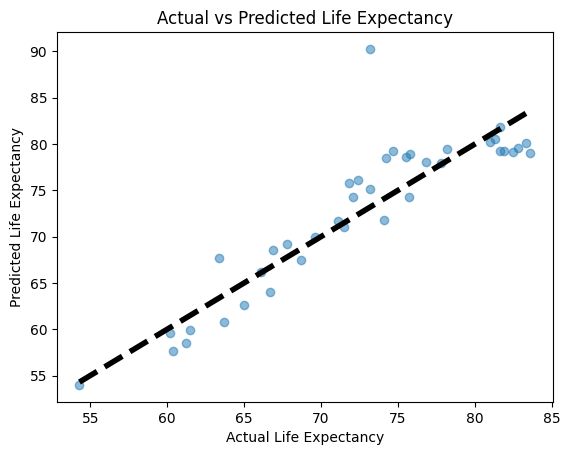

In [54]:
y_pred = best_model.predict(X_test_top_features)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Actual vs Predicted Life Expectancy')
plt.show()

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error

k = 5

scorer_rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False))
scorer_mae = make_scorer(mean_absolute_error)
scorer_r2 = make_scorer(r2_score)

# Perform k-fold cross-validation for each metric
cv_scores_rmse = cross_val_score(best_model, X, y, cv=k, scoring=scorer_rmse)
cv_scores_mae = cross_val_score(best_model, X, y, cv=k, scoring=scorer_mae)
cv_scores_r2 = cross_val_score(best_model, X, y, cv=k, scoring=scorer_r2)

# Calculate the mean and standard deviation for each metric
mean_rmse = cv_scores_rmse.mean()
std_rmse = cv_scores_rmse.std()
mean_mae = cv_scores_mae.mean()
std_mae = cv_scores_mae.std()
mean_r2 = cv_scores_r2.mean()
std_r2 = cv_scores_r2.std()

# Print out the results
print(f'RMSE: {mean_rmse:.2f} (std: {std_rmse:.2f})')
print(f'MAE: {mean_mae:.2f} (std: {std_mae:.2f})')
print(f'R-squared: {mean_r2:.2f} (std: {std_r2:.2f})')

RMSE: 3.23 (std: 0.38)
MAE: 2.27 (std: 0.26)
R-squared: 0.80 (std: 0.05)


In [56]:
import optuna

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 100.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
    positive = trial.suggest_categorical('positive', [True, False])   

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, selection=selection, tol=tol, positive=positive, random_state=42, copy_X=True, max_iter=1000000)
    model.fit(X_train_top_features, y_train_full)
    y_pred_test = model.predict(X_test_top_features)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    print(f"RMSE: {rmse_test} | MAE: {mae_test} | R2: {r2_test}")
    return rmse_test

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = study.best_value

print("Best parameters:", best_params)
print("Best score:", best_score)

[I 2024-04-24 19:23:20,559] A new study created in memory with name: no-name-894c8ba3-372d-4fd7-9848-8a20257a5df6
[I 2024-04-24 19:23:20,565] Trial 0 finished with value: 7.542315673797299 and parameters: {'alpha': 14.221568825193362, 'l1_ratio': 0.928463644140318, 'selection': 'cyclic', 'tol': 0.05358155398260207, 'positive': False}. Best is trial 0 with value: 7.542315673797299.
[I 2024-04-24 19:23:20,570] Trial 1 finished with value: 4.032134095371153 and parameters: {'alpha': 0.08925651548045714, 'l1_ratio': 0.32048581699367085, 'selection': 'cyclic', 'tol': 0.03580106929581341, 'positive': False}. Best is trial 1 with value: 4.032134095371153.
[I 2024-04-24 19:23:20,575] Trial 2 finished with value: 8.776722032236702 and parameters: {'alpha': 0.000320055023154985, 'l1_ratio': 0.7958258463013959, 'selection': 'random', 'tol': 0.02682350074194673, 'positive': True}. Best is trial 1 with value: 4.032134095371153.
[I 2024-04-24 19:23:20,580] Trial 3 finished with value: 8.149810817274

RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007
RMSE: 4.032134095371153 | MAE: 2.5374348001817473 | R2: 0.7141600705797513
RMSE: 8.776722032236702 | MAE: 4.460080065078237 | R2: -0.35430864360031866
RMSE: 8.149810817274778 | MAE: 4.3134698185597244 | R2: -0.1677450022477609
RMSE: 5.948254195077736 | MAE: 4.8327146325583294 | R2: 0.37794039344326313
RMSE: 8.76225342791611 | MAE: 4.452502558099111 | R2: -0.3498471135486332
RMSE: 5.230513663088703 | MAE: 3.9871567729272956 | R2: 0.5190038014803113
RMSE: 4.375955310252806 | MAE: 3.5961793893536447 | R2: 0.6633344191357251
RMSE: 8.759047636156998 | MAE: 4.45392284831127 | R2: -0.3488595737150286
RMSE: 3.7480991228915337 | MAE: 2.6298814636447196 | R2: 0.7530124297205328
RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007
RMSE: 3.927754164397763 | MAE: 2.518955335279284 | R2: 0.7287676056863941
RMSE: 3.7865347461118337 | MAE: 2.5810713156440577 | R2: 0.7479208910913602
RMSE: 3.78655

[I 2024-04-24 19:23:20,768] Trial 15 finished with value: 3.5733737536432253 and parameters: {'alpha': 0.37897673488420963, 'l1_ratio': 0.4619032469863783, 'selection': 'cyclic', 'tol': 0.0008197598901862495, 'positive': False}. Best is trial 15 with value: 3.5733737536432253.
[I 2024-04-24 19:23:20,790] Trial 16 finished with value: 3.5265753154819084 and parameters: {'alpha': 0.45526463170378884, 'l1_ratio': 0.4418498996437151, 'selection': 'cyclic', 'tol': 0.0002871096353477708, 'positive': False}. Best is trial 16 with value: 3.5265753154819084.
[I 2024-04-24 19:23:20,813] Trial 17 finished with value: 3.735780685040887 and parameters: {'alpha': 0.2177612790566749, 'l1_ratio': 0.44878914786781965, 'selection': 'cyclic', 'tol': 0.00022090855633012378, 'positive': False}. Best is trial 16 with value: 3.5265753154819084.
[I 2024-04-24 19:23:20,836] Trial 18 finished with value: 3.7963078360048357 and parameters: {'alpha': 0.005812750770765564, 'l1_ratio': 0.5472648774560256, 'selectio

RMSE: 3.5733737536432253 | MAE: 2.462998529568909 | R2: 0.7755033583269373
RMSE: 3.5265753154819084 | MAE: 2.4697966879218103 | R2: 0.7813450624269542
RMSE: 3.735780685040887 | MAE: 2.4661106613164936 | R2: 0.7546332520195693
RMSE: 3.7963078360048357 | MAE: 2.5684310091565914 | R2: 0.7466179736555847
RMSE: 3.101503548088569 | MAE: 2.440148468306441 | R2: 0.8308790042992438
RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007
RMSE: 3.649417758614044 | MAE: 2.4745327479656836 | R2: 0.7658467854412074
RMSE: 3.2362426310562986 | MAE: 2.44772908093528 | R2: 0.8158655235458987
RMSE: 3.8235685840930103 | MAE: 2.550943675118824 | R2: 0.7429659073002713
RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007
RMSE: 3.2511042157008365 | MAE: 2.459799043054347 | R2: 0.8141704630610704


[I 2024-04-24 19:23:20,985] Trial 26 finished with value: 3.0081580291320935 and parameters: {'alpha': 1.1071138413865362, 'l1_ratio': 0.5787423410164566, 'selection': 'random', 'tol': 7.982833110890891e-05, 'positive': False}. Best is trial 26 with value: 3.0081580291320935.
[I 2024-04-24 19:23:21,000] Trial 27 finished with value: 7.542315673797299 and parameters: {'alpha': 9.09810618954974, 'l1_ratio': 0.8112813718712153, 'selection': 'random', 'tol': 4.772599210697726e-05, 'positive': False}. Best is trial 26 with value: 3.0081580291320935.
[I 2024-04-24 19:23:21,017] Trial 28 finished with value: 3.134063501194851 and parameters: {'alpha': 1.347425471570999, 'l1_ratio': 0.9721371507049232, 'selection': 'random', 'tol': 1.6773830984073907e-05, 'positive': False}. Best is trial 26 with value: 3.0081580291320935.
[I 2024-04-24 19:23:21,031] Trial 29 finished with value: 7.542315673797299 and parameters: {'alpha': 26.772435143580278, 'l1_ratio': 0.9071623662071826, 'selection': 'rando

RMSE: 3.0081580291320935 | MAE: 2.4512132052558586 | R2: 0.8409058329072957
RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007
RMSE: 3.134063501194851 | MAE: 2.5002175048028614 | R2: 0.8273094607370846
RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007
RMSE: 3.827171536527514 | MAE: 2.5562239662183153 | R2: 0.74248127211538
RMSE: 3.087007086593139 | MAE: 2.480747968775558 | R2: 0.8324562563841378
RMSE: 3.166267311874153 | MAE: 2.515486722404437 | R2: 0.8237422925950918
RMSE: 3.571778721154669 | MAE: 2.472653974510076 | R2: 0.7757037289259743
RMSE: 4.854029487161677 | MAE: 3.9852952951358964 | R2: 0.585754515838621
RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007
RMSE: 3.654303641140206 | MAE: 2.482640272585966 | R2: 0.7652193917003112
RMSE: 7.486841399611633 | MAE: 6.158758164704603 | R2: 0.01451452282782395
RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007


[I 2024-04-24 19:23:21,200] Trial 39 finished with value: 4.434859846699903 and parameters: {'alpha': 1.3436127878459145, 'l1_ratio': 0.8673091231439353, 'selection': 'random', 'tol': 4.7012273372063664e-05, 'positive': True}. Best is trial 26 with value: 3.0081580291320935.
[I 2024-04-24 19:23:21,218] Trial 40 finished with value: 4.191087780451558 and parameters: {'alpha': 2.9596905878213944, 'l1_ratio': 0.8000427557220242, 'selection': 'random', 'tol': 0.00047175727858686457, 'positive': False}. Best is trial 26 with value: 3.0081580291320935.
[I 2024-04-24 19:23:21,234] Trial 41 finished with value: 3.036002281007031 and parameters: {'alpha': 1.0070854021884093, 'l1_ratio': 0.9921828314720883, 'selection': 'random', 'tol': 0.0001252495460318944, 'positive': False}. Best is trial 26 with value: 3.0081580291320935.
[I 2024-04-24 19:23:21,250] Trial 42 finished with value: 3.1481857054322155 and parameters: {'alpha': 1.3673979572392643, 'l1_ratio': 0.9429638871675837, 'selection': 'ra

RMSE: 4.434859846699903 | MAE: 3.5749672719313197 | R2: 0.6542097359364107
RMSE: 4.191087780451558 | MAE: 3.4559286709009163 | R2: 0.6911792479188661
RMSE: 3.036002281007031 | MAE: 2.477044275738437 | R2: 0.837946972404565
RMSE: 3.1481857054322155 | MAE: 2.508031936914411 | R2: 0.8257496546514684
RMSE: 3.802722181844392 | MAE: 2.516135073574669 | R2: 0.745761007847986
RMSE: 2.976631682693581 | MAE: 2.4263800490269847 | R2: 0.8442230622708491
RMSE: 7.406364846375588 | MAE: 4.089659050507103 | R2: 0.03558675455778093
RMSE: 3.787125641805205 | MAE: 2.5796319032398705 | R2: 0.7478422101379378
RMSE: 3.026479194220105 | MAE: 2.43124452212557 | R2: 0.8389620076647795
RMSE: 5.052938761838928 | MAE: 4.15129527009938 | R2: 0.5511088615809016
RMSE: 8.58100528063451 | MAE: 4.409547500337104 | R2: -0.29458121434242845
RMSE: 3.739803334189092 | MAE: 3.102565749062913 | R2: 0.7541045508822659


[I 2024-04-24 19:23:21,412] Trial 51 finished with value: 2.938671388695643 and parameters: {'alpha': 0.8666136784687537, 'l1_ratio': 0.6465327914022458, 'selection': 'random', 'tol': 0.00031388478394947815, 'positive': False}. Best is trial 51 with value: 2.938671388695643.
[I 2024-04-24 19:23:21,427] Trial 52 finished with value: 2.9231088871164115 and parameters: {'alpha': 0.8097685299497049, 'l1_ratio': 0.6619653517161658, 'selection': 'random', 'tol': 0.00033287108534314774, 'positive': False}. Best is trial 52 with value: 2.9231088871164115.
[I 2024-04-24 19:23:21,444] Trial 53 finished with value: 3.1681049557994765 and parameters: {'alpha': 0.6940828527333007, 'l1_ratio': 0.6550313031354924, 'selection': 'random', 'tol': 0.09580914656467972, 'positive': False}. Best is trial 52 with value: 2.9231088871164115.
[I 2024-04-24 19:23:21,460] Trial 54 finished with value: 3.6824720495024224 and parameters: {'alpha': 0.22737429146079144, 'l1_ratio': 0.5080674896124739, 'selection': 'r

RMSE: 2.938671388695643 | MAE: 2.410670571951687 | R2: 0.8481709021542094
RMSE: 2.9231088871164115 | MAE: 2.403079244467463 | R2: 0.8497747453497985
RMSE: 3.1681049557994765 | MAE: 2.5295115843786227 | R2: 0.8235376396925375
RMSE: 3.6824720495024224 | MAE: 2.459837490620905 | R2: 0.7615859306265726
RMSE: 3.8117244032272675 | MAE: 2.4894720315849983 | R2: 0.7445558581518221
RMSE: 3.1108398198371496 | MAE: 2.447986886168507 | R2: 0.8298592820427295
RMSE: 6.1606028572916625 | MAE: 5.050483018180974 | R2: 0.3327333980013406
RMSE: 3.7665125387909977 | MAE: 3.110971960457227 | R2: 0.7505796999663286
RMSE: 3.6255417996643904 | MAE: 2.4499445093904293 | R2: 0.7689006120096435
RMSE: 3.090736223487311 | MAE: 2.443951464549291 | R2: 0.8320512226950346
RMSE: 3.4501864248988774 | MAE: 2.8349448122752627 | R2: 0.7907150077534645
RMSE: 3.283079433930384 | MAE: 2.4321617827167312 | R2: 0.8104971510742858
RMSE: 3.1199464395891794 | MAE: 2.454597636755051 | R2: 0.8288616899028111


[I 2024-04-24 19:23:21,621] Trial 64 finished with value: 7.542315673797299 and parameters: {'alpha': 12.18170123352732, 'l1_ratio': 0.8962481211409226, 'selection': 'random', 'tol': 0.002907481440238591, 'positive': False}. Best is trial 52 with value: 2.9231088871164115.
[I 2024-04-24 19:23:21,637] Trial 65 finished with value: 3.0796237257741423 and parameters: {'alpha': 0.4135648280852046, 'l1_ratio': 0.8452136513004544, 'selection': 'random', 'tol': 0.0002433407085771681, 'positive': False}. Best is trial 52 with value: 2.9231088871164115.
[I 2024-04-24 19:23:21,661] Trial 66 finished with value: 3.2861180118080795 and parameters: {'alpha': 0.2975803487069872, 'l1_ratio': 0.8171716765090713, 'selection': 'random', 'tol': 0.00025549351136010533, 'positive': False}. Best is trial 52 with value: 2.9231088871164115.
[I 2024-04-24 19:23:21,699] Trial 67 finished with value: 3.662986355426023 and parameters: {'alpha': 0.1287411882669474, 'l1_ratio': 0.777246504366213, 'selection': 'rand

RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007
RMSE: 3.0796237257741423 | MAE: 2.4215856085448135 | R2: 0.833256744711358
RMSE: 3.2861180118080795 | MAE: 2.4184237259452854 | R2: 0.8101462088298944
RMSE: 3.662986355426023 | MAE: 2.4602771835469244 | R2: 0.7641023773829172
RMSE: 4.907586297582262 | MAE: 4.027414880332913 | R2: 0.5765629526574432
RMSE: 3.8636251964830257 | MAE: 2.5259552475050415 | R2: 0.7375521970346232
RMSE: 8.738685094110808 | MAE: 4.445886975593828 | R2: -0.3425953575644254
RMSE: 3.0066045854169845 | MAE: 2.4175842416784157 | R2: 0.8410701062052941
RMSE: 3.046742656274446 | MAE: 2.42105641059612 | R2: 0.8367983639095047
RMSE: 3.4318015984732195 | MAE: 2.7713250520885455 | R2: 0.7929394770139122


[I 2024-04-24 19:23:21,829] Trial 74 finished with value: 2.958866345760003 and parameters: {'alpha': 0.9026413832410068, 'l1_ratio': 0.901305986142762, 'selection': 'random', 'tol': 5.8779828290259366e-05, 'positive': False}. Best is trial 52 with value: 2.9231088871164115.
[I 2024-04-24 19:23:21,849] Trial 75 finished with value: 3.0082746892482373 and parameters: {'alpha': 1.0465522775058234, 'l1_ratio': 0.8965736615596575, 'selection': 'random', 'tol': 2.8613558254030976e-05, 'positive': False}. Best is trial 52 with value: 2.9231088871164115.
[I 2024-04-24 19:23:21,866] Trial 76 finished with value: 6.340604660305041 and parameters: {'alpha': 7.11897778388584, 'l1_ratio': 0.590739083604497, 'selection': 'random', 'tol': 2.6257005104578655e-05, 'positive': False}. Best is trial 52 with value: 2.9231088871164115.
[I 2024-04-24 19:23:21,883] Trial 77 finished with value: 7.542315673797299 and parameters: {'alpha': 18.879613517721612, 'l1_ratio': 0.8932193207805443, 'selection': 'rand

RMSE: 2.958866345760003 | MAE: 2.397540004969432 | R2: 0.8460769506234833
RMSE: 3.0082746892482373 | MAE: 2.4341187646504303 | R2: 0.8408934929279994
RMSE: 6.340604660305041 | MAE: 5.1997665781616345 | R2: 0.2931710752193286
RMSE: 7.542315673797299 | MAE: 6.2128698224852075 | R2: -0.00014362895173603007
RMSE: 3.786536198898709 | MAE: 2.5810067325860913 | R2: 0.7479206976599957
RMSE: 3.9326077203879413 | MAE: 2.48956066296554 | R2: 0.7280968636157232
RMSE: 3.4237765537610607 | MAE: 2.805106166706732 | R2: 0.7939067398663432
RMSE: 2.9608116405976426 | MAE: 2.398642519279545 | R2: 0.8458744919068917
RMSE: 2.914695291403643 | MAE: 2.3907170071106534 | R2: 0.8506382886616143
RMSE: 3.0176315827585665 | MAE: 2.4339096223437804 | R2: 0.8399021885564582
RMSE: 2.9235838440628115 | MAE: 2.398695078024464 | R2: 0.8497259231350826
RMSE: 2.912694858133735 | MAE: 2.3915511041298494 | R2: 0.8508432401735965


[I 2024-04-24 19:23:22,032] Trial 85 finished with value: 2.912694858133735 and parameters: {'alpha': 0.5482773574762162, 'l1_ratio': 0.9243584854775563, 'selection': 'random', 'tol': 5.342571404767063e-05, 'positive': False}. Best is trial 85 with value: 2.912694858133735.
[I 2024-04-24 19:23:22,049] Trial 86 finished with value: 2.9268295481848483 and parameters: {'alpha': 0.5050259046641609, 'l1_ratio': 0.9615529363271529, 'selection': 'random', 'tol': 6.377288951358993e-05, 'positive': False}. Best is trial 85 with value: 2.912694858133735.
[I 2024-04-24 19:23:22,065] Trial 87 finished with value: 5.889532511488605 and parameters: {'alpha': 0.48632649345389656, 'l1_ratio': 0.9659477314782685, 'selection': 'random', 'tol': 5.356295261017093e-05, 'positive': True}. Best is trial 85 with value: 2.912694858133735.
[I 2024-04-24 19:23:22,082] Trial 88 finished with value: 3.2061095483216246 and parameters: {'alpha': 0.3272858943403652, 'l1_ratio': 0.8721352892956572, 'selection': 'rando

RMSE: 2.9268295481848483 | MAE: 2.4009972064800857 | R2: 0.8493920753925805
RMSE: 5.889532511488605 | MAE: 3.7834656180429707 | R2: 0.3901618219453139
RMSE: 3.2061095483216246 | MAE: 2.4188408361894993 | R2: 0.8192785604847876
RMSE: 3.4591318020530335 | MAE: 2.4532499585105447 | R2: 0.7896283649355214
RMSE: 3.669619305159388 | MAE: 2.4730639639222667 | R2: 0.7632472752335748
RMSE: 3.2238421677349898 | MAE: 2.5619966445974987 | R2: 0.81727393352376
RMSE: 2.9182138466632814 | MAE: 2.390407636459262 | R2: 0.8502774587353339
RMSE: 2.91301906531462 | MAE: 2.390979615252189 | R2: 0.8508100335479281
RMSE: 2.9142426391518668 | MAE: 2.3914769779014615 | R2: 0.8506846768143195
RMSE: 2.926887314064557 | MAE: 2.4027079264074738 | R2: 0.8493861303349902
RMSE: 2.9271508711255447 | MAE: 2.402895221791605 | R2: 0.8493590044966546
RMSE: 3.2378329933623413 | MAE: 2.4246952224626868 | R2: 0.8156845034443827


[I 2024-04-24 19:23:22,260] Trial 98 finished with value: 2.919907525066013 and parameters: {'alpha': 0.5353223929055143, 'l1_ratio': 0.946333471737516, 'selection': 'cyclic', 'tol': 0.00017400111764768003, 'positive': False}. Best is trial 85 with value: 2.912694858133735.
[I 2024-04-24 19:23:22,277] Trial 99 finished with value: 2.916323212211986 and parameters: {'alpha': 0.6150856990316312, 'l1_ratio': 0.9404661006146791, 'selection': 'cyclic', 'tol': 0.0001264946794643613, 'positive': False}. Best is trial 85 with value: 2.912694858133735.


RMSE: 2.919907525066013 | MAE: 2.393641440986697 | R2: 0.8501036158060493
RMSE: 2.916323212211986 | MAE: 2.391302718600712 | R2: 0.8504713985303599
Best parameters: {'alpha': 0.5482773574762162, 'l1_ratio': 0.9243584854775563, 'selection': 'random', 'tol': 5.342571404767063e-05, 'positive': False}
Best score: 2.912694858133735


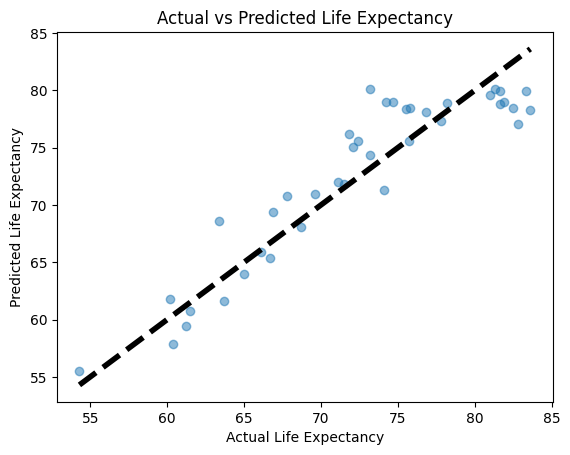

In [57]:
best_model = ElasticNet(**best_params, random_state=42, copy_X=True, max_iter=1000000)
best_model.fit(X_train_top_features, y_train_full)
y_pred = best_model.predict(X_test_top_features)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Actual vs Predicted Life Expectancy')
plt.show()

In [58]:
feature_importance = best_model.coef_

pd.DataFrame(feature_importance, index=columns_to_be_kept, columns=['Importance'])

,Importance
Population: Labor force participation (%),-0.000000
Out of pocket health expenditure,-0.000000
Land Area(Km2),-0.000000
Co2-Emissions,-0.000000
CPI,-0.000000
Gross tertiary education enrollment (%),0.338745
Birth Rate,-1.735765
Forested Area (%),-0.000000
Maternal mortality ratio,-0.768967
Fertility Rate,-0.212529


In [59]:
import numpy as np
from scipy.stats import pearsonr

correlations = []
for i in range(X.shape[1]):
    correlation, _ = pearsonr(X_test[:, i], y_pred)
    correlations.append(correlation)

for i, correlation in enumerate(correlations):
    print(f"Pearson correlation between input variable {X.columns[i]} and output variable: {correlation}")


Pearson correlation between input variable Density
(P/Km2) and output variable: 0.17438603539551634
Pearson correlation between input variable Agricultural Land( %) and output variable: -0.2176074874477486
Pearson correlation between input variable Land Area(Km2) and output variable: -0.49393174115135985
Pearson correlation between input variable Armed Forces size and output variable: 0.062320918334880446
Pearson correlation between input variable Birth Rate and output variable: -0.95476042074795
Pearson correlation between input variable Co2-Emissions and output variable: 0.4047884834295869
Pearson correlation between input variable CPI and output variable: -0.7416904128203058
Pearson correlation between input variable CPI Change (%) and output variable: -0.5669089802574234
Pearson correlation between input variable Fertility Rate and output variable: -0.92881913114359
Pearson correlation between input variable Forested Area (%) and output variable: -0.018167315599366185
Pearson corre

In [60]:
k = 5

# Perform k-fold cross-validation for each metric
cv_scores_rmse = cross_val_score(best_model, X, y, cv=k, scoring=scorer_rmse)
cv_scores_mae = cross_val_score(best_model, X, y, cv=k, scoring=scorer_mae)
cv_scores_r2 = cross_val_score(best_model, X, y, cv=k, scoring=scorer_r2)

# Calculate the mean and standard deviation for each metric
mean_rmse = cv_scores_rmse.mean()
std_rmse = cv_scores_rmse.std()
mean_mae = cv_scores_mae.mean()
std_mae = cv_scores_mae.std()
mean_r2 = cv_scores_r2.mean()
std_r2 = cv_scores_r2.std()

# Print out the results
print(f'RMSE: {mean_rmse:.2f} (std: {std_rmse:.2f})')
print(f'MAE: {mean_mae:.2f} (std: {std_mae:.2f})')
print(f'R-squared: {mean_r2:.2f} (std: {std_r2:.2f})')

RMSE: 3.46 (std: 0.56)
MAE: 2.33 (std: 0.31)
R-squared: 0.77 (std: 0.07)
